In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
!pip install ignite

In [3]:
import time
import ignite
import numpy as np
import sklearn.metrics
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import transforms
from typing import List, Callable
import pickle
import tqdm
import pytorch_lightning as pl
import torchmetrics
import os.path
import cv2
import csv
import pandas as pd
#from google.colab import drive
from google.colab.patches import cv2_imshow
import fnmatch
from math import sqrt
from PIL import Image
import joblib
from torch_lr_finder import LRFinder

/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


In [4]:
print(torch.cuda.is_available())
print(torch.__version__)

True
1.8.1+cu101


## Parameters

In [55]:
BATCH_SIZE = 32
EPOCHS = 20
LR = 1e-4
WD = 1e-4

## Data Classes

In [6]:
# Modificamos la carpeta 
print(os.getcwd())
os.chdir("Pruebas ImitAI/400 datos + 10 Imagenes")
#os.chdir("../Prueba")
os.listdir()

/home/hodei.zia/ImitAI Project


['Test_dataset', 'Train_dataset', 'MinMax_scaler.save', 'lightning_logs']

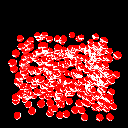

In [7]:
def red_merge(carpeta_imagenes):
    
    length = len(fnmatch.filter(os.listdir(carpeta_imagenes + "Front_rgb/"), '*.png'))
    path = carpeta_imagenes + "Front_rgb/0.png"
    img = cv2.imread(path,1)
    aux = np.zeros(np.shape(img))
    
    for idx in range(length):
        path = carpeta_imagenes + "Front_rgb/" + str(idx) + ".png"

        #blurring and smoothin
        img=cv2.imread(path,1)

        hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
        lower_red = np.array([0,50,50])
        upper_red = np.array([10,255,255])

        mask = cv2.inRange(hsv, lower_red, upper_red)
        res = cv2.bitwise_and(img,img, mask= mask)

        aux = aux + res
    return aux

res = red_merge("Train_dataset/")
cv2_imshow(res)

In [8]:
os.getcwd()

'/home/hodei.zia/ImitAI Project/Pruebas ImitAI/400 datos + 10 Imagenes'

/home/hodei.zia/ImitAI Project/Pruebas ImitAI/400 datos + 10 Imagenes


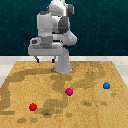

CPU times: user 149 ms, sys: 105 ms, total: 254 ms
Wall time: 665 ms


In [9]:
%%time
print(os.getcwd())
for i in range(1000):
    im = Image.open("Test_dataset/Front_rgb/"+str(i)+".png")
display(im)

/home/hodei.zia/ImitAI Project/Pruebas ImitAI/400 datos + 10 Imagenes


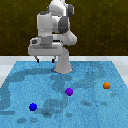

CPU times: user 668 ms, sys: 51.3 ms, total: 719 ms
Wall time: 724 ms


In [10]:
%%time
print(os.getcwd())
for i in range(1000):
    image = cv2.imread("Test_dataset/Front_rgb/"+str(i)+".png")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cv2_imshow(image)

### Normalizamos las acciones

In [11]:
print(os.getcwd())
print(os.listdir())
with open('Train_dataset/Train_Actions.csv') as f:
    lines = (line for line in f if not line.startswith('#'))
    x = np.loadtxt(lines, delimiter=',', skiprows=1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(x)
x_transformed = scaler.transform(x)
np.savetxt('Train_dataset/Train_Actions_Normalized.csv',x_transformed , delimiter=',', header="X1,X2,X3,X4,X5,X6,X7")

with open('Test_dataset/Test_Actions.csv') as f:
    lines = (line for line in f if not line.startswith('#'))
    x = np.loadtxt(lines, delimiter=',', skiprows=1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(x)
x_transformed = scaler.transform(x)
np.savetxt('Test_dataset/Test_Actions_Normalized.csv',x_transformed , delimiter=',', header="X1,X2,X3,X4,X5,X6,X7")

/home/hodei.zia/ImitAI Project/Pruebas ImitAI/400 datos + 10 Imagenes
['Test_dataset', 'Train_dataset', 'MinMax_scaler.save', 'lightning_logs']


In [12]:
x_transformed.min(axis=0)

array([-1., -1., -1., -1., -1., -1., -1.])

In [13]:
scaler_filename = "MinMax_scaler.save"
scaler_to_save = MinMaxScaler(feature_range=(-1, 1))
joblib.dump(scaler_to_save, scaler_filename) 
scaler = joblib.load(scaler_filename) 

In [56]:
# Clases para mas de una imagen

class ObsActionGetter(object):
    """
    Generic class that return the image and the action given an index
    """
    def __init__(self, carpeta_imagenes, archivo_acciones):
        # TODO: get a list of all image files
        self.archivo_acciones = archivo_acciones
        self.carpeta_imagenes = carpeta_imagenes
        path, dirs, files = next(os.walk(self.carpeta_imagenes))
        self.image_files = list(range(len(files)))
        # TODO: get all made actions
        self.actions = []
        
    def __len__(self):
        return len(fnmatch.filter(os.listdir(self.carpeta_imagenes + "Front_rgb/"), '*.png'))
        
    def __getitem__(self, idx):
        path_1 = self.carpeta_imagenes + "Front_rgb/" + str(idx) + ".png"
        path_2 = self.carpeta_imagenes + "Left_rgb/" + str(idx) + ".png"
        path_3 = self.carpeta_imagenes + "Right_rgb/" + str(idx) + ".png"
        path_4 = self.carpeta_imagenes + "Front_depth/" + str(idx) + ".png"
        path_5 = self.carpeta_imagenes + "Overhead_rgb/" + str(idx) + ".png"

        im1 = np.array(Image.open(path_1))  
        im2 = np.array(Image.open(path_2)) 
        im3 = np.array(Image.open(path_3)) 
        im4 = np.array(Image.open(path_4))  
        im5 = np.array(Image.open(path_5))
        
        #image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)
        #image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)
        #image_3 = cv2.cvtColor(image_3, cv2.COLOR_BGR2RGB)

        if (idx == 0):
            im6 = np.array(Image.open(path_1))  
            im7 = np.array(Image.open(path_2)) 
            im8 = np.array(Image.open(path_3)) 
            im9 = np.array(Image.open(path_4))  
            im10 = np.array(Image.open(path_5)) 

        else :
            path_6 = self.carpeta_imagenes + "Front_rgb/" + str(idx-1) + ".png"
            path_7 = self.carpeta_imagenes + "Left_rgb/" + str(idx-1) + ".png"
            path_8 = self.carpeta_imagenes + "Right_rgb/" + str(idx-1) + ".png"
            path_9 = self.carpeta_imagenes + "Front_depth/" + str(idx-1) + ".png"
            path_10 = self.carpeta_imagenes + "Overhead_rgb/" + str(idx-1) + ".png"

            im6 = np.array(Image.open(path_6))  
            im7 = np.array(Image.open(path_7)) 
            im8 = np.array(Image.open(path_8)) 
            im9 = np.array(Image.open(path_9))  
            im10 = np.array(Image.open(path_10))
            
        #image_4 = cv2.cvtColor(image_4, cv2.COLOR_BGR2RGB)
        #image_5 = cv2.cvtColor(image_5, cv2.COLOR_BGR2RGB)
        #image_6 = cv2.cvtColor(image_6, cv2.COLOR_BGR2RGB)
            
        # TODO: get the action
        data = pd.read_csv(self.archivo_acciones, header = 0)
        action = np.float32(np.array(data.iloc[idx]))
        if (idx == 0):
            action_prev = np.array([0,0,0,0,0,0,0], dtype="float32")
        else:
            action_prev = np.float32(np.array(data.iloc[idx-1]))
        
        # Return both image and action
        return im1, im2, im3, im4, im5, im6, im7, im8, im9, im10, action, action_prev

class ObsActionDataset(Dataset):
    """
    PyTorch Dataset for getting the data. In this case, from ObsActionGetter object
    """
    def __init__(self, obs_action_getter: ObsActionGetter, transformations: List[Callable]):
        super(ObsActionDataset, self).__init__()
        self.obs_action_getter = obs_action_getter
        self.transformations = transformations
        
    def __len__(self):
        return len(self.obs_action_getter)
    
    def __getitem__(self, idx):
        im1, im2, im3, im4, im5, im6, im7, im8, im9, im10, action, action_prev = self.obs_action_getter[idx]
        # Transform image
        for t in self.transformations:
            im1 = t(im1)
            im2 = t(im2)
            im3 = t(im3)
            im4 = t(im4)
            im5 = t(im5)
            im6 = t(im6)
            im7 = t(im7)
            im8 = t(im8)
            im9 = t(im9)
            im10 = t(im10)
        # Return both image and action
        return (im1, im2, im3, im4, im5, im6, im7, im8, im9, im10, action_prev), action

class MultiImage(nn.Module):
    def __init__(self, fe, clf):
        super(MultiImage, self).__init__()
        self.fe = fe
        self.clf = clf
        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
    def forward(self, x):
        x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11 = x
        f1 = self.fe(x1)
        f2 = self.fe(x2)
        f3 = self.fe(x3)
        f4 = self.fe(x4)
        f5 = self.fe(x5)
        f6 = self.fe(x6)
        f7 = self.fe(x7)
        f8 = self.fe(x8)
        f9 = self.fe(x9)
        f10 = self.fe(x10)
        f = torch.cat((f1, f2, f3, f4, f5, f6, f7, f8, f9, f10), dim=1)
        f = self.flatten(self.avg_pool(f))
        f = torch.cat((f, x11), dim=1)
        return self.clf(f)

In [57]:
print(len(fnmatch.filter(os.listdir('Test_dataset/Front_rgb'), '*.png')))
print(len(fnmatch.filter(os.listdir('Test_dataset/Right_rgb'), '*')))
print(len(fnmatch.filter(os.listdir('Test_dataset/Left_rgb'), '*')))
print(len(fnmatch.filter(os.listdir('Test_dataset/Overhead_rgb'), '*')))
print(len(fnmatch.filter(os.listdir('Test_dataset/Front_depth'), '*')))
print(len(fnmatch.filter(os.listdir('Train_dataset/Front_rgb'), '*')))
print(len(fnmatch.filter(os.listdir('Train_dataset/Right_rgb'), '*')))
print(len(fnmatch.filter(os.listdir('Train_dataset/Left_rgb'), '*')))
print(len(fnmatch.filter(os.listdir('Train_dataset/Overhead_rgb'), '*')))
print(len(fnmatch.filter(os.listdir('Train_dataset/Front_depth'), '*')))

1803
1803
1803
1803
1803
16537
16537
16537
16537
16537


In [58]:
# Control de errores
'''
# Por longitud
files_copy = files
print(len(files_copy))
for i in range(8808):
    foto = str(i) + ".png"
    if foto in files_copy:
        files_copy.remove(foto)
        
print(files_copy)'''

'\n# Por longitud\nfiles_copy = files\nprint(len(files_copy))\nfor i in range(8808):\n    foto = str(i) + ".png"\n    if foto in files_copy:\n        files_copy.remove(foto)\n        \nprint(files_copy)'

In [59]:
# Para mas de una imagen

# Create train Dataset.
# The ToTensor transform converts the image to Tensor in [0, 1] range and makes it channel first
# The Normalize transform normalizes the tensor using Imagenet stats

train_obs_action_getter = ObsActionGetter('Train_dataset/', 'Train_dataset/Train_Actions_Normalized.csv')
train_dataset = ObsActionDataset(train_obs_action_getter, 
                                [
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                ])

# Create test Dataset.
# The ToTensor transform converts the image to Tensor in [0, 1] range and makes it channel first
# The Normalize transform normalizes the tensor using Imagenet stats

test_obs_action_getter = ObsActionGetter('Test_dataset/', 'Test_dataset/Test_Actions_Normalized.csv')
test_dataset = ObsActionDataset(test_obs_action_getter, 
                                [
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                ])

16537
516
1803
57


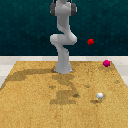

<class 'numpy.ndarray'>

Accion Previa: [0. 0. 0. 0. 0. 0. 0.]

Accion Actual: [ 0.02592112 -0.26550657  0.03722794  0.05761727  0.02385747 -0.43496087
  0.00886366]

Accion Previa del siguiente: [ 0.02592112 -0.26550657  0.03722794  0.05761727  0.02385747 -0.43496087
  0.00886366] 


[ 0.02592112 -0.26550657  0.03722794  0.05761727  0.02385747 -0.43496087
  0.00886366]
CPU times: user 427 ms, sys: 46.7 ms, total: 474 ms
Wall time: 362 ms


In [60]:
%%time
# Create loaders (class that groups examples in batches)
# Uriz: train DataLoader should have shuffle to True
# Uriz: test DataLoader should have drop_last to False
# Uriz: use more workers to improve the training speed (load data in sever CPU threads). Otherwise we have a CPU -> GPU bottleneck
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=16)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=16)

print(len(train_dataset))
print(len(train_loader))
print(len(test_dataset))
print(len(test_loader))

display(Image.fromarray((train_obs_action_getter[1][0]), 'RGB'))
print(type(train_obs_action_getter[1][7][0]))
print("\nAccion Previa:", train_obs_action_getter[0][11])
print("\nAccion Actual:", train_obs_action_getter[0][10])
print("\nAccion Previa del siguiente:", train_obs_action_getter[1][11],"\n\n")
print(train_dataset[1][0][10])

In [61]:
it = iter(test_loader)
first = next(it)
second = next(it)
print(it)


## Model

We use a pretrained ResNet18 for now. We have to remove the classifier head because it is traiend for classification with 1000 classes. We add a custom head to make regression of 7 values

In [62]:
# To pretrain
model = models.resnet18(pretrained=True)

# Get only the feature extractor (remove avgpool and fc layers)
fe = nn.Sequential(*list(model.children())[:-2])

def freeze_all_but_bn(m):
    """
    Function that set a module as no trainable (not required grad) only if it is not a BatchNorm module
    Args:
        m: PyTorch Module
    """
    if not isinstance(m, torch.nn.modules.batchnorm._BatchNorm):
        if hasattr(m, 'weight') and m.weight is not None:
            m.weight.requires_grad_(False)
        if hasattr(m, 'bias') and m.bias is not None:
            m.bias.requires_grad_(False)
            
# Freeze all but BatchNorm layers of feature extractor
# Uriz: if we use the "normal" ResNet use the pretained version and freeze all but BN
#       only set all trainiable when we change the fitst convolution layer to accept images of 6 dimensions
#       if the ResNet is pretrained and freezed the training accuracy is maintained (or increased) and the train time is dreceased
fe.apply(freeze_all_but_bn) # Solo usar si no se preentrena la red

# Create custom head
head_clf = nn.Sequential(
    nn.BatchNorm1d(512*10 + 7), 
    nn.Dropout(0.25),
    nn.Linear(512*10 + 7, 512), 
    nn.ReLU(),
    nn.BatchNorm1d(512),   
    nn.Dropout(0.25),
    nn.Linear(512, 7)
)

# Rebuild the model
model = MultiImage(fe, head_clf)

## Train Model

In [63]:
# Create trainable class with Pytorch Lightinng
class LitModel(pl.LightningModule):
    def __init__(self, model, loss_function, total_iterations, lr):
        """
        Constructor of the trainable class
        Args:
            model: PyTorch model
            loss_function: The loss function to use
            total_iterations: The total number of iterations for training (num_batches * num_epochs). Used for
                                LR Schedule
            lr: the max_lr to use for the OneCycleLR policy
        """
        super().__init__()
        # Store params
        self.model = model
        self.loss_function = loss_function
        self.total_iterations = total_iterations
        self.lr = lr
        # For measure the MSE
        self.train_mse = torchmetrics.MeanSquaredError()
        self.valid_mse = torchmetrics.MeanSquaredError()

    def forward(self, x):
        # Forward method
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        prediction = self(x)
        loss = self.loss_function(prediction, y)
        # Get MSE
        self.train_mse(prediction, y)
        # Log loss and MSE
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_mse', self.train_mse, on_step=True, on_epoch=False, prog_bar=True)
        # Return Loss for backward
        return loss

    def training_epoch_end(self, outs):
        # log epoch metric
        self.log('train_acc_epoch', self.train_mse.compute())

    def validation_step(self, batch, batch_idx):
        x, y = batch
        prediction = self(x)
        loss = self.loss_function(prediction, y)
        # Get MSE
        self.valid_mse(prediction, y)
        # Log loss and MSE
        self.log('valid_loss', loss, prog_bar=True)
        self.log('val_mse', self.valid_mse, on_step=True, on_epoch=False, prog_bar=True)
        return loss

    def validation_epoch_end(self, outs):
        # log epoch metric
        self.log('val_acc_epoch', self.valid_mse.compute())

    def configure_optimizers(self):
        # Get Adam optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        # Set OneCycleLR policy
        lr_scheduler = {
            'scheduler': torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=self.lr,
                                                             total_steps=self.total_iterations),
            'interval': 'step', 'frequency': 1, 'name': 'lr_logger'
        }
        print(optimizer)
        return [optimizer], [lr_scheduler]

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 6.58E-03


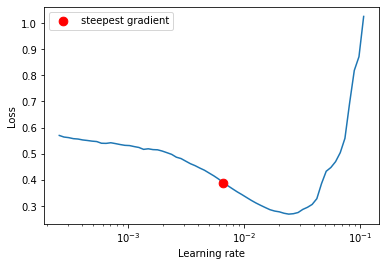

In [139]:
# Loss function
criterion = nn.MSELoss()

# We catch the optimizer of our lit_model
# optimizer, lr_scheduler = pl_model.configure_optimizers()
optimizer = optim.Adam(model.parameters(), lr=LR)

# Learning State Finder
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=1, num_iter=100, step_mode="exp")
lr_finder.plot()
lr_finder.reset()

In [ ]:
# Create trainer class
BEST_LR = 6.58E-03

# Number of iterations for LR Schedule
ITERATIONS_PER_EPOCH = len(train_loader)

# Create PytorchLighting model for training
pl_model = LitModel(model, criterion, total_iterations=ITERATIONS_PER_EPOCH * EPOCHS, lr=BEST_LR)

NUM_GPUS = 1 if torch.cuda.is_available() else 0
trainer = pl.Trainer(auto_lr_find=True, min_epochs=EPOCHS, max_epochs=EPOCHS,
                     log_every_n_steps=1, gpus=NUM_GPUS)

# Train the model
trainer.fit(pl_model, train_loader, val_dataloaders=test_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MultiImage       | 13.8 M
1 | loss_function | MSELoss          | 0     
2 | train_mse     | MeanSquaredError | 0     
3 | valid_mse     | MeanSquaredError | 0     
---------------------------------------------------
2.7 M     Trainable params
11.2 M    Non-trainable params
13.8 M    Total params
55.268    Total estimated model params size (MB)


Adam (
Parameter Group 0
    amsgrad: False
    base_momentum: 0.85
    betas: (0.95, 0.999)
    eps: 1e-08
    initial_lr: 0.0002632
    lr: 0.0002631999999999999
    max_lr: 0.00658
    max_momentum: 0.95
    min_lr: 2.632e-08
    weight_decay: 0
)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

## Make Predictions and Save the Model

In [371]:
# Put model on eval mode so we change the BatchNorm and Dropout layers behaviour
model = model.eval()
# Set device ("cuda" or GPU if cuda is installed, otherwise in "cpu")
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# To concatenate predictions and labels
predictions = None
labels = None
# Surround all for not computing gradients
with torch.no_grad():
    # Iterate over test dataset
    for x, y in tqdm.notebook.tqdm(test_loader):
        # Move to device
        #x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11 = x
        x1, x2, x3, x5, x6, x7, x8, x10, x11 = x
        x1 = x1.to(device)
        x2 = x2.to(device)
        x3 = x3.to(device)
        #x4 = x4.to(device)
        x5 = x5.to(device)
        x6 = x6.to(device)
        x7 = x7.to(device)
        x8 = x8.to(device)
        #x9 = x9.to(device)
        x10 = x10.to(device)
        x11 = x11.to(device)
        # Predict
        #o = model((x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11))
        o = model((x1, x2, x3, x5, x6, x7, x8, x10, x11))
        # Concatenate
        if predictions is None:
            predictions = o
        else:
            predictions = torch.cat((predictions, o), axis=0)

        if labels is None:
            labels = y
        else:
            labels = torch.cat((labels, y), axis=0)
    
    # Move predictions to CPU and to numpy
    predictions = predictions.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()

mse = sklearn.metrics.mean_squared_error(labels, predictions)
rmse = sqrt(mse)
print("El valor del error cudratico medios (MSE) es igual a " + str(mse))
print("El valor RMSE es igual a " + str(rmse))

  0%|          | 0/57 [00:00<?, ?it/s]

El valor del error cudratico medios (MSE) es igual a 0.06604961
El valor RMSE es igual a 0.2570011927181799


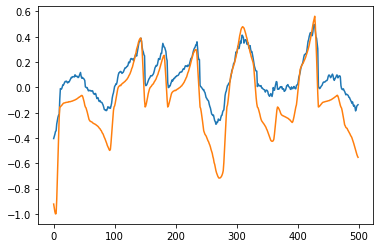

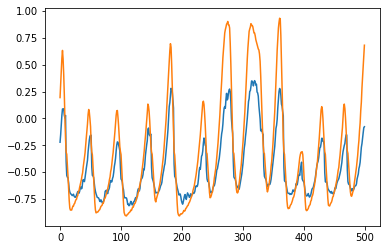

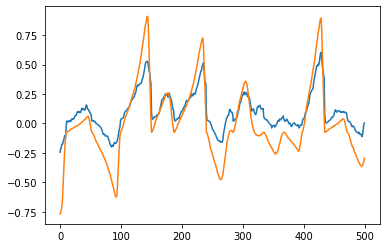

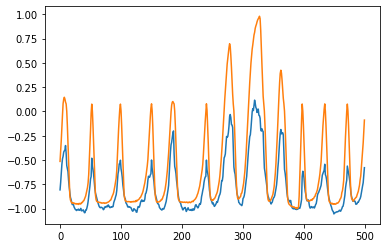

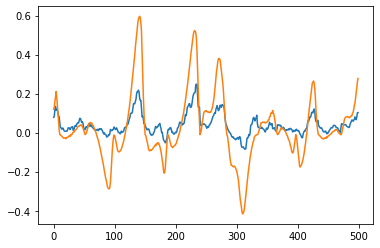

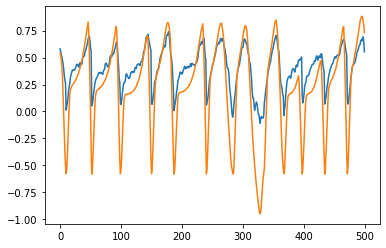

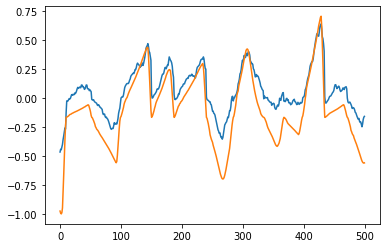

In [372]:
import matplotlib.pyplot as plt

for i in range(7):
    plt.plot(predictions[500:1000, i], label='prediction')
    plt.plot(labels[500:1000, i], label='target')
    plt.show()

In [373]:
# Error promedio de cada una de las articulaciones
joint_error = np.zeros(7)
minimo = np.zeros(7)
maximo = np.zeros(7)
for i in range(7):
    joint_error[i] = sqrt(sklearn.metrics.mean_squared_error(predictions[:, i], labels[:, i]))
    minimo[i] = min(labels[:, i])
    maximo[i] = max(labels[:, i])
    
print(joint_error)

for i in range(7):
    print("Articulacion " + str(i) + " [" + str(round(minimo[i], 2)) + " - " + str(round(maximo[i], 2)) + "] " +
          str(round(abs(round(minimo[i], 2) - round(maximo[i], 2)),2))
          , str(round(joint_error[i]*100/round(abs(round(minimo[i], 2) - round(maximo[i], 2)),2),2)) + "%")

[0.23928687 0.28792056 0.21015615 0.3362455  0.14209578 0.30422512
 0.22851691]
Articulacion 0 [-1.0 - 1.0] 2.0 11.96%
Articulacion 1 [-1.0 - 1.0] 2.0 14.4%
Articulacion 2 [-1.0 - 1.0] 2.0 10.51%
Articulacion 3 [-1.0 - 1.0] 2.0 16.81%
Articulacion 4 [-1.0 - 1.0] 2.0 7.1%
Articulacion 5 [-1.0 - 1.0] 2.0 15.21%
Articulacion 6 [-1.0 - 1.0] 2.0 11.43%


In [ ]:
#path, dirs, files = next(os.walk("Train_dataset"))
print(os.getcwd())
os.chdir("Train_dataset")

df=pd.read_csv('Train_Actions.csv')

#FINDING MAX AND MIN
p=df.max()
q=df.min()


print(q, p)

os.chdir("../Test_dataset")

df=pd.read_csv('Test_Actions.csv')

#FINDING MAX AND MIN
p=df.max()
q=df.min()

print(q, p)
os.chdir("../")

In [282]:
print(model)
torch.save(model, 'model_pytorch_500it_norm_')
model = torch.load('model_pytorch_500it_norm_')
model.eval()

MultiImage(
  (fe): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

MultiImage(
  (fe): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 